In [13]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential 
from keras.layers import Dense,GlobalAveragePooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from keras.applications import inception_resnet_v2
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import glob 
import cv2

#### Loading the dataset

In [7]:
import pathlib

dataset = pathlib.Path("lung_colon_image_set/lung_image_sets/")
images = list(dataset.glob('*/*.jpeg'))

In [8]:
lbt = dataset.glob('lung_n/*')
laca = dataset.glob('lung_aca/*')
lscc = dataset.glob('lung_scc/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)

In [9]:
label_dict = {
    'lung_benign_tissue' : 0,
    'lung_adenocarcinoma' : 1,
    'lung_squamous_cell_carcinoma' : 2,
}

image_dict = {
    'lung_benign_tissue' : lung_benign_tissue,
    'lung_adenocarcinoma' : lung_adenocarcinoma,
    'lung_squamous_cell_carcinoma' : lung_squamous_cell_carcinoma,
}

#### Preprocessing

In [14]:
x,y = [],[]

for name,images in tqdm(image_dict.items(), desc='Processing Images'):
    for img in tqdm(images, desc=f'Processing {name} Images', leave=False):
        i = cv2.imread(str(img))
        resized_image = cv2.resize(i,(200,200))
        resized_image = resized_image.astype(np.float16)/255.0
        resized_image = np.round(resized_image,4)
        x.append(resized_image)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

Processing Images: 100%|██████████| 3/3 [03:05<00:00, 61.78s/it]


#### Splitting the dataset for training and testing

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)
x_train.shape

(10500, 200, 200, 3)

#### Building the model

In [16]:
model = Sequential()
inc_res_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [17]:
history = model.fit(x_train,y_train_cat,epochs=10,batch_size=8)

Epoch 1/10
1313/1313 [==============================] - 571s 425ms/step - loss: 0.1803 - accuracy: 0.9308
Epoch 2/10
1313/1313 [==============================] - 551s 420ms/step - loss: 0.1189 - accuracy: 0.9523
Epoch 3/10
1313/1313 [==============================] - 553s 421ms/step - loss: 0.0984 - accuracy: 0.9614
Epoch 4/10
1313/1313 [==============================] - 555s 422ms/step - loss: 0.0889 - accuracy: 0.9658
Epoch 5/10
1313/1313 [==============================] - 567s 432ms/step - loss: 0.0709 - accuracy: 0.9708
Epoch 6/10
1313/1313 [==============================] - 559s 426ms/step - loss: 0.0704 - accuracy: 0.9720
Epoch 7/10
1313/1313 [==============================] - 559s 426ms/step - loss: 0.0700 - accuracy: 0.9718
Epoch 8/10
1313/1313 [==============================] - 564s 429ms/step - loss: 0.0647 - accuracy: 0.9728
Epoch 9/10
1313/1313 [==============================] - 567s 432ms/step - loss: 0.0585 - accuracy: 0.9753
Epoch 10/10
1313/1313 [=======================

In [18]:
model_hist=pd.DataFrame(history.history)

#### Model Evaluation

In [19]:
y_test_cat=to_categorical(y_test,num_classes=3)
model.evaluate(x_test,y_test_cat)

141/141 [==============================] - 219s 2s/step - loss: 0.0528 - accuracy: 0.9773


[0.05284532532095909, 0.9773333072662354]

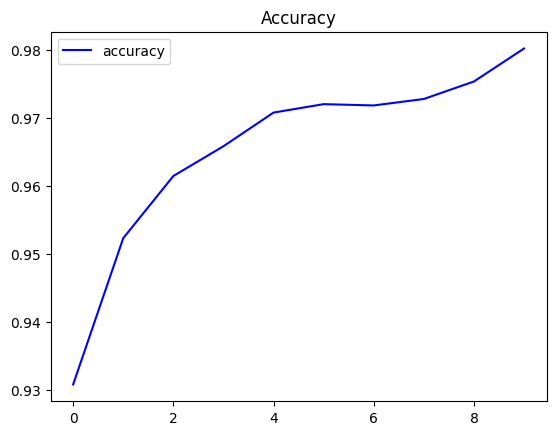

In [20]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

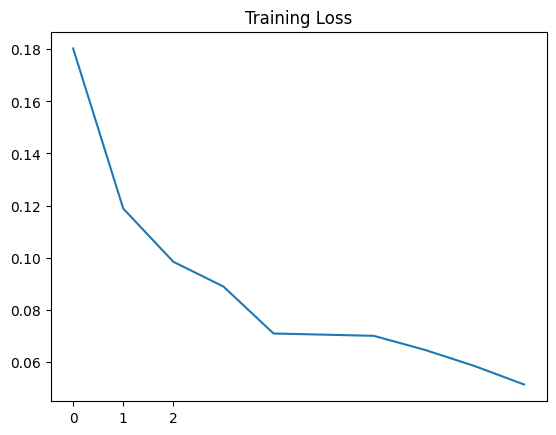

In [21]:
x=list(range(0,3))
plt.plot(model_hist['loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()

In [22]:
y_pred_model=model.predict(x_test)
y_pred_model=np.argmax(y_pred_model,axis=1)
print(classification_report(y_pred_model,y_test))

141/141 [==============================] - 214s 1s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1480
           1       0.97      0.96      0.97      1562
           2       0.96      0.97      0.97      1458

    accuracy                           0.98      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.98      0.98      0.98      4500



In [23]:
accuracy_score(y_test,y_pred_model)

0.9773333333333334

In [ ]:
model.save(model1.h5)